# Part 3: Planning and learning
We now look at some other interesting capabilities of the model network.

### A partial aside: Planning new sequences by transforming spatial input patterns into spatiotemporal sequences
If we take a closer look at how history-dependent excitability allows replay we see that it occurs through a separation of spatial and temporal information. After a sequence is presented for the first time, its "footprint" is left as a spatial pattern of increased excitability. All the temporal information that is needed to fully replay the pattern, however, is contained in the connectivity structure of the network, or rather in the intrinsic activity distributions. When these two are combined together, the full pattern can be replayed. 

This elucidates key constraints on replayable patterns. While in this simplified model one can store the spatial information of essentially any original pattern, one can only use the temporal patterns that previously exist in the connectivity matrix. One therefore expects a greatly weakened ability to replay patterns that do not align with these templates.

Such a separation of spatial and temporal information suggests the interesting possibility that specific sequences could be "loaded" into the network without ever having to *play* them in the first place. Instead, another "brain region" could provide a steady, purely spatial multi-node input, containing the identities of the nodes to be activated but not their order, and the intrinsic temporal structure of the network would order the spatial input into a sequence. That is, one could *plan* out a sequence via a purely spatial representation.

Below I show how this would work in the model. In the first time step I present a strong external drive to (black-0) to force that node to activate first. In the subsequent timesteps, however, I present the purely spatial input pattern (represented as external drive) of (black-1, red-2, red-3) (which could also therefore be written as (red-3, black-1, red-2), for instance). Since there is a weak connection between (black-1) and (red-2) the internal structure of this network could convert this spatial pattern into the sequence (black-1, red-2, red-3).

In [3]:
%matplotlib inline
import softmax_chains_planning_and_learning

In [2]:
CONFIG_PLANNING = {
    'SEED': None,
    
    'N_CHAINS': 9,  # HOW MANY CHAINS
    'CHAIN_LENGTH': 4,  # HOW MANY NODES PER CHAIN
    
    'W_STRONG': 2,  # STRENGTH OF STRONG CONNECTIONS (WITHIN CHAINS)
    'W_WEAK': 1,  # STRENGTH OF WEAK CONNECTIONS (BETWEEN CHAINS)
    'WEAK_CXN_IDXS': (2, 1),  # WHICH NODES SHOULD BE USED TO CONNECT CHAINS
    
    'GAIN': 6,  # GAIN USED IN WTA MECHANISM
    'HDE_INPUT_VALUE': 1,  # HOW STRONG THE HISTORY-DEPENDENT INPUT IS
    
    # FIRST DRIVE (BLACK-0) FOR ONE TIMESTEP
    # THEN SIMULTANEOUSLY DRIVE (BLACK-1, RED-2, RED-3) FOR THE NEXT THREE TIMESTEPS
    'DRIVE_MULTI_BY_COORDINATE': [
            [([(0, 0), 2],),
             ([(0, 1), 1.], [(1, 2), 1.5], [(1, 3), 1.5]),
             ([(0, 1), 1.], [(1, 2), 1.5], [(1, 3), 1.5]),
             ([(0, 1), 1.], [(1, 2), 1.5], [(1, 3), 1.5])]
            for _ in range(6)
        ],

    'N_TRIALS': 6,
    
    'FIG_SIZE': (15, 8),
    'COLORS': [
            (0, 0, 0),(1, 0, 0), (0, 1, 0), (0, 0, 1), (0, 1, 1),
            (1, 0, 1), (.5, .5, 0), (.5, .5, .5), (.5, 0, 0)
        ],
    'LW': 2,
    'FONT_SIZE': 16,
}

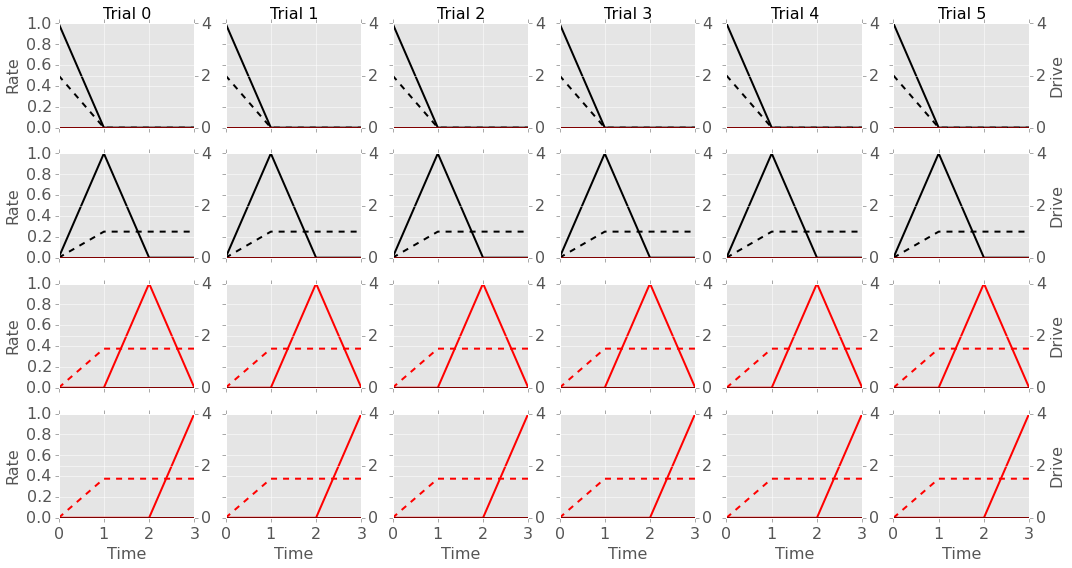

In [3]:
softmax_chains_planning_and_learning.planning(CONFIG_PLANNING)

#### Figure description
As expected, we see that even though the input (dashed line) is purely spatial the temporal sequence (black-0, black-1, red-2, red-3) is played reliably. This demonstrates how the connectivity strucutre of the network could be used to convert a spatial input into a spatiotemporal pattern.

### Back to the original goals: One-shot learning of new sequences (via replay)
The ability of this model network with history-dependent excitability to replay novel sequences suggests that such a feature could be used to learn to new sequences that have been presented only once. I explore how this might occur by adding to the model a simplified version of spike-timing-dependent plasticity (STDP). The hypothesis is that even though an individual STDP event would lead to only a very weak increase in synaptic strength, if the sequence were replayed a lot, the resulting series of increases could become significant. To implement this I include the following STDP: if two nodes are connected, then if they are sequentially activated their connection strength $w$ increases by

$$\Delta w = \alpha(w_{max} - w),$$

where $\alpha$ is a learning rate and $w_{max}$ is the maximum possible connection weight.

Note that for the sake of simplicity here, I include no forgetting/decay of synaptic weights. Additionally, since I now depart from immediate replay and examine much longer post-stimulus timescales, I add a timescale $\tau_{hde}$ to the history-dependent excitability, before which the history-dependent excitability remains constant and after which the history-dependent excitability gets set to zero.

In [1]:
CONFIG_LEARNING = {
    'SEED': None,
    
    'N_CHAINS': 9,  # HOW MANY CHAINS
    'CHAIN_LENGTH': 4,  # HOW MANY NODES PER CHAIN
    
    'W_STRONG': 2,  # STRENGTH OF WITHIN-CHAIN CONNECTIONS
    'W_WEAK': 1,  # STRENGTH OF BETWEEN-CHAIN CONNECTIONS
    'WEAK_CXN_IDXS': (2, 1),  # WHICH NODES TO USE TO WEAKLY BIND CHAINS TOGETHER (TO, FROM)
    
    'GAIN': 3.5,  # GAIN IN WTA CIRCUIT
    'HDE_INPUT_VALUE': 1.5,  # HISTORY-DEPENDENT-EXCITABILITY INPUT VALUE
    'HDE_TIMESCALE': 20,  # TIMESCALE AFTER WHICH HDE INPUT IS SET TO ZERO
    
    'ALPHA': .1,  # LEARNING RATE
    'W_MAX': 2,  # MAXIMUM WEIGHT
    
    # THE BELOW DRIVES THE SEQUENCE (BLACK-0, BLACK-1, RED-2, RED-3) IN THE FIRST 4 TIMESTEPS,
    # LETS THE NETWORK RUN SPONTANEOUSLY FOR THE NEXT 80 TIMESTEPS, AND THEN DRIVES BLACK-1
    # ONCE EVERY FOUR TIMESTEPS FOR SEVERAL REPETITIONS, TO SEE WHICH SEQUENCE IT TRIGGERS
    'DRIVE_BY_COORDINATE': [
            [((0, chain_pos), 3) if chain_pos < 2 else ((1, chain_pos), 3) for chain_pos in range(4)] + 
            80* [((0, 0), 0)] +
            10 * [((0, 0), 3), ((0, 0), 0), ((0, 0), 0), ((0, 0), 0)]
            for _ in range(8)
        ],

    'N_TRIALS': 8,  # NUMBER OF TRIALS
    'WS_TO_TRACK': [
            [(1, 2), (0, 1)]  # TRACK THE WEIGHT OF THE CONNECTION TO NODE 2 IN THE RED CHAIN (CHAIN 0)
        ],                    # FROM NODE 1 IN THE BLACK CHAIN (CHAIN 1) [(NODE TO, NODE FROM), (CHAIN TO, CHAIN FROM)]
    
    'FIG_SIZE': (15, 8),
    'COLORS': [
            (0, 0, 0),(1, 0, 0), (0, 1, 0), (0, 0, 1), (0, 1, 1),
            (1, 0, 1), (.5, .5, 0), (.5, .5, .5), (.5, 0, 0)
        ],
    'LW': 2,
    'FONT_SIZE': 16,
}

We run a bunch of trials now, seeing how well the network can learn the sequence (black-0, black-1, red-2, red-3) after only a single presentation. We begin with a connectivity structure as shown in the diagram below. Further, we examine how the weak connection to red-2 from black-1 changes over time.

<img src="files/softmax_chains_weak_links.png" width="500">

### The figure below
Below, each block is one trial, and the trial runs for many time steps. Each color again corresponds to one chain and each row to one position in the chain, so that sequences can be identified visually in the same way as before.

During the first 4 timesteps of each trial the sequence (black-0, black-1, red-2, red-3) is presented via external drive. Then the network is allowed to run spontaneously for many timesteps. Around timestep 85, (black-0) is activated by external drive once every 4 timesteps, to probe what sequence it triggers.

The last plot in each block tracks the connection strength to (red-2) from (black-1), which can change via the STDP learning rule.

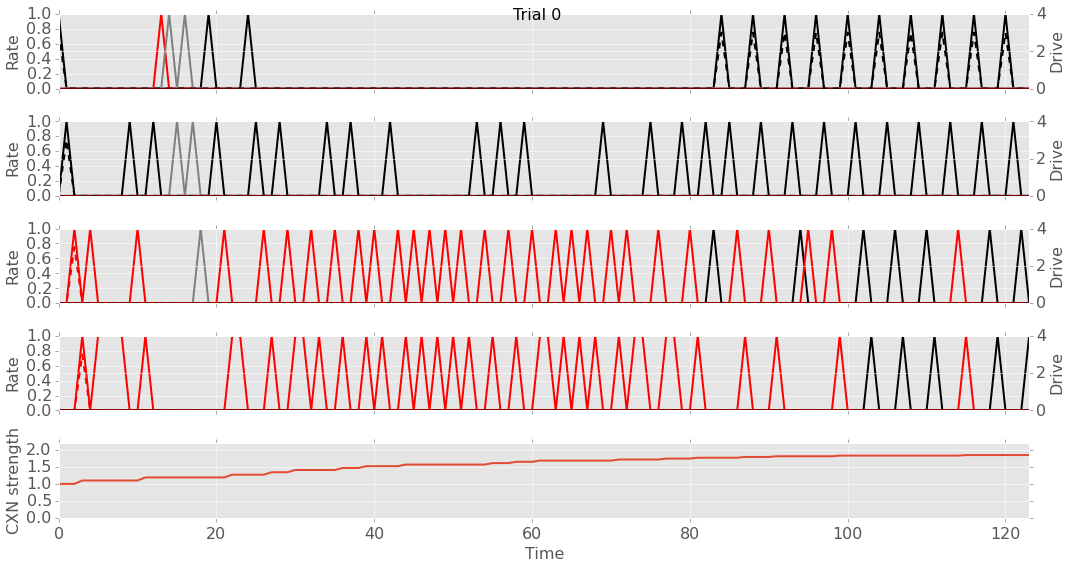

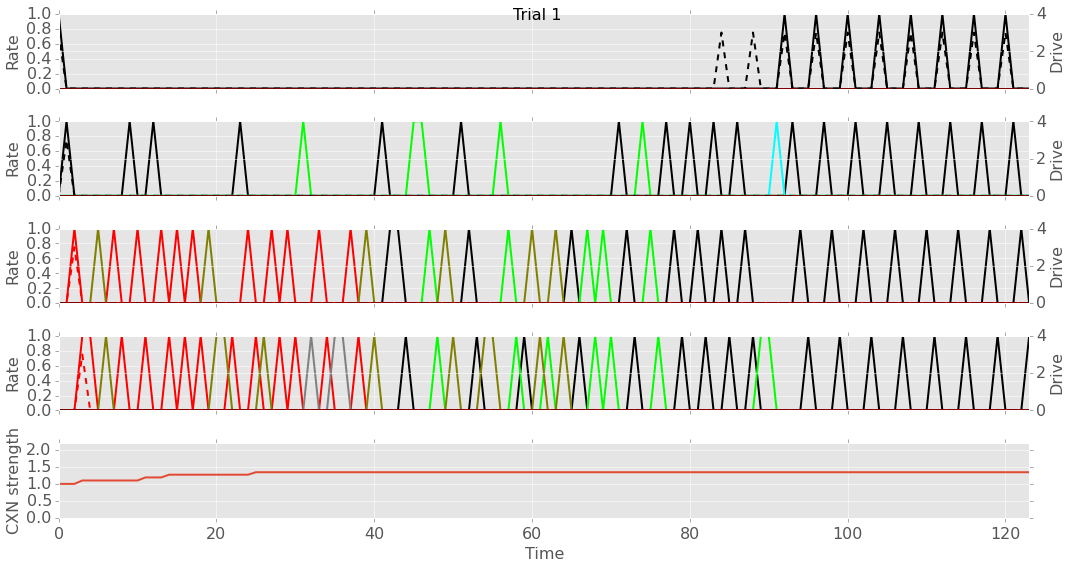

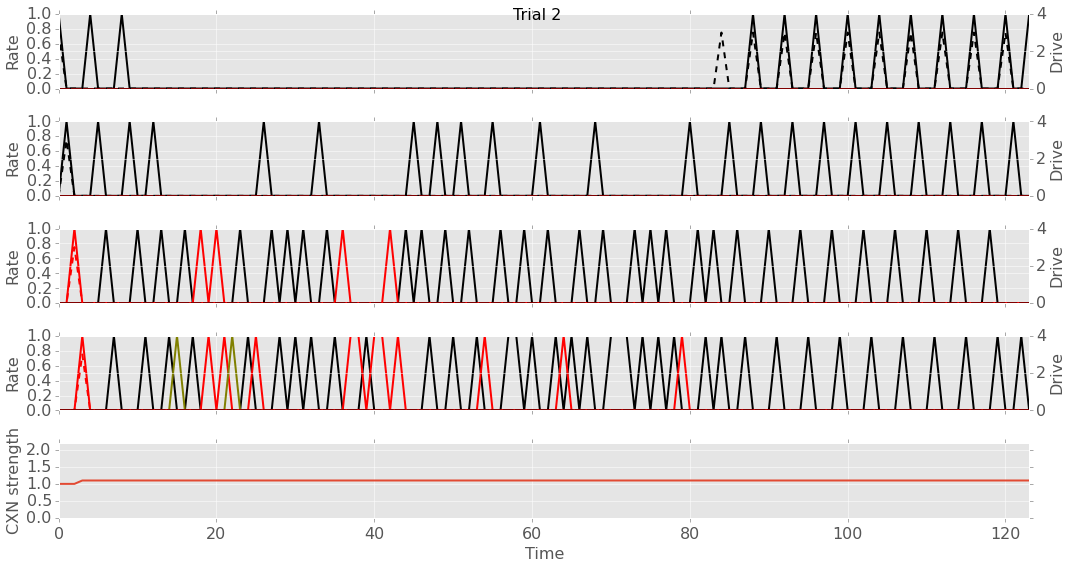

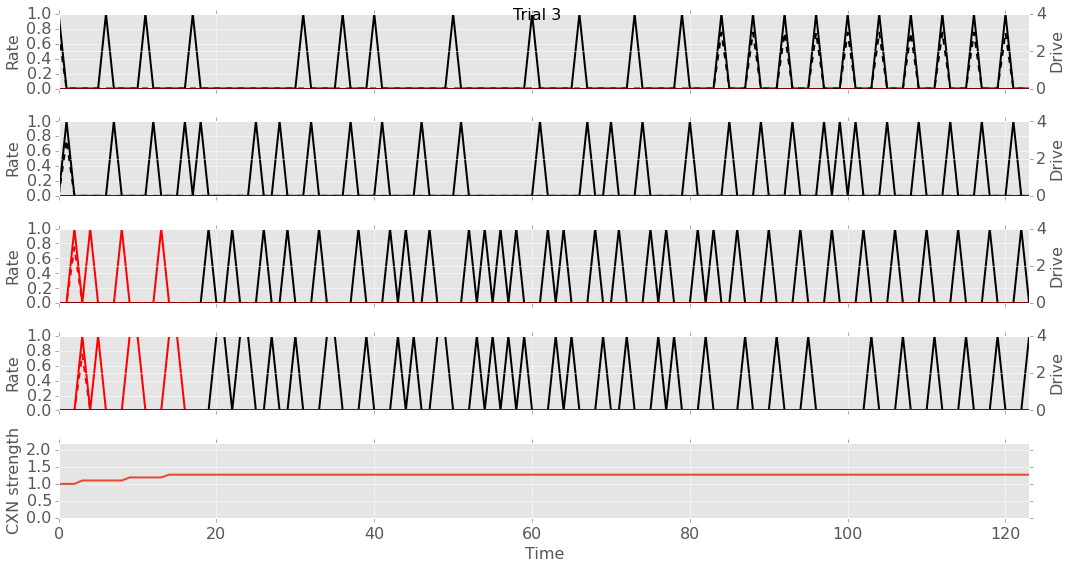

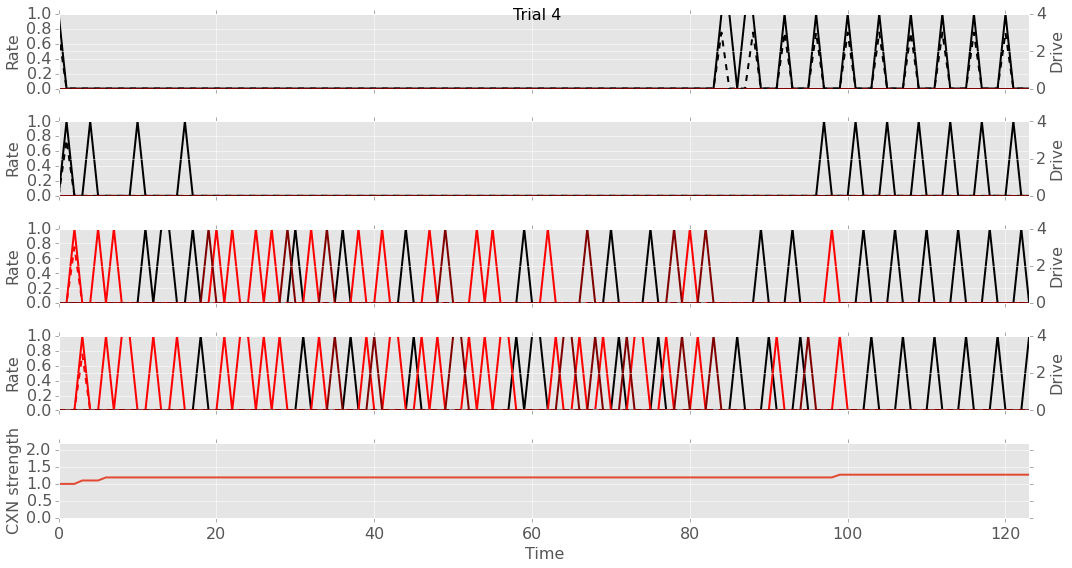

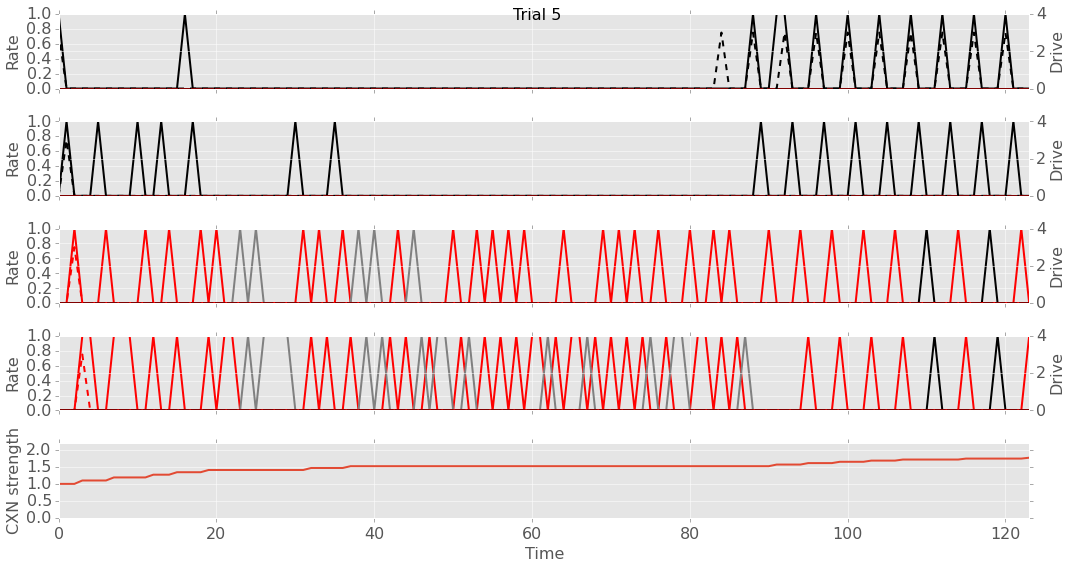

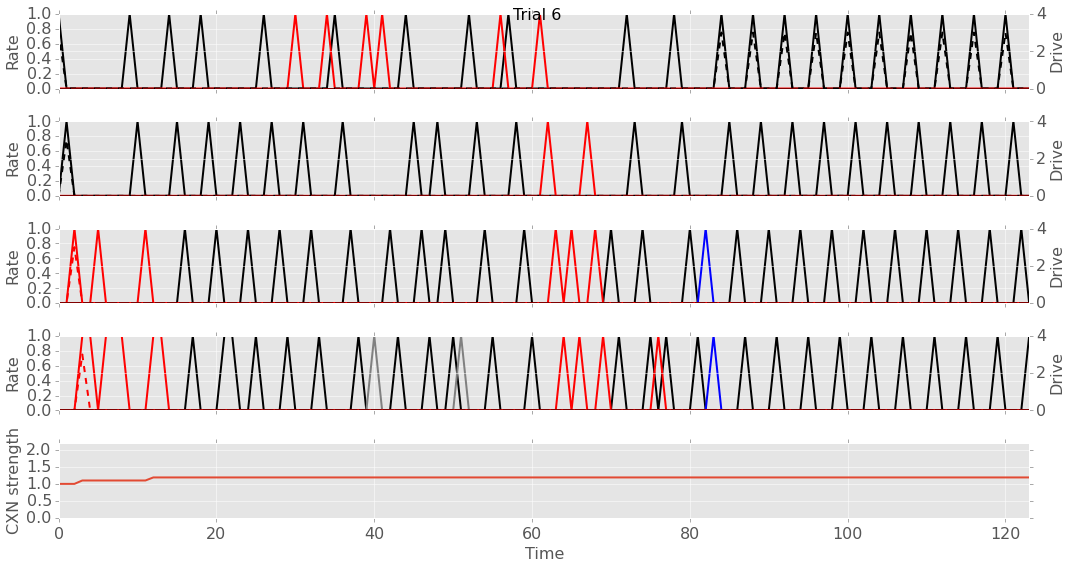

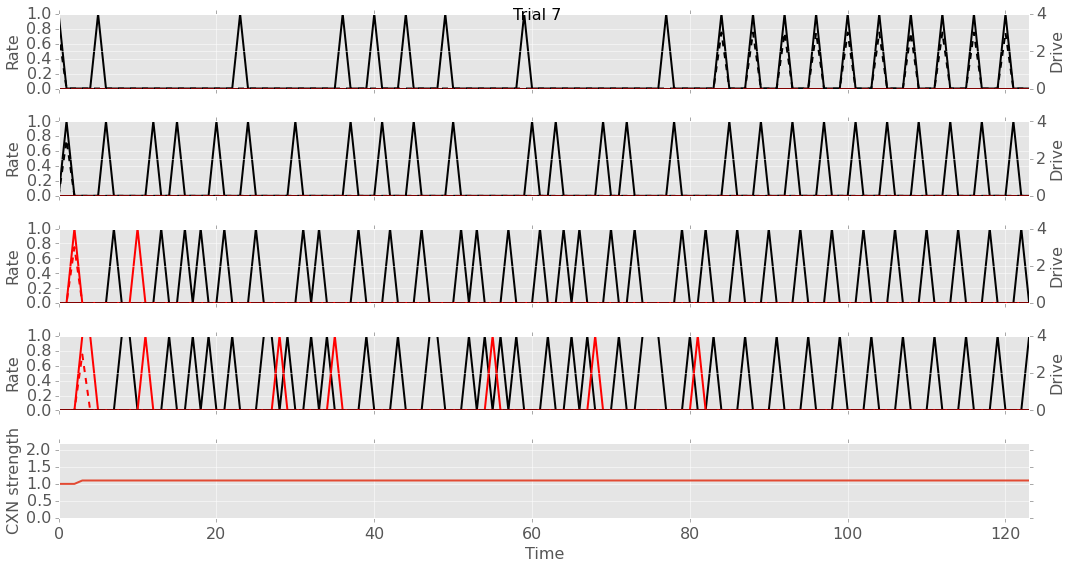

In [4]:
softmax_chains_planning_and_learning.learning(CONFIG_LEARNING)

#### Figure description
Several interesting things are happening here. First, as expected, whenever the sequence (black-1, red-2) activates, the connection between the two nodes increases in strength. Next, in some trials (e.g., Trial 1) the novel sequence activates spontaneously quite often. At the end of the trials, when (black-0) is activated to explore the sequence it triggers, there is a lot of variability. Sometimes this will trigger (black-0, black-1, black-2, black-3), and sometimes it will trigger (black-0, black-1, red-2, red-3). The probability of the latter sequence getting triggered increases with the strength of the connection to (red-2) from (black-1). This means that the more times (black-1, red-2) is replayed, the stronger the corresponding connection becomes, and the more it gets burned into the intrinsic activity distribution. We also see that these aspects of the model do not necessarily prevent the other chains from activating, although there is certainly a strong preference for the red and black chains to dominate.

### Summary of Part 3
In part 3 I've gone through a brief analysis of how the model works, i.e., by showing how spatial and temporal information get teased apart, such that representations and replay depend on the connectivity structure of the network. I've also shown how if an STDP rule gets added to the model, this replay can trigger the network to burn in the novel patterns even after only a single stimulus presentation, and the extent that these patterns get burned in depends on how often they occur during subsequent spontaneous activity.